In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [25]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
TIMESTEPS = 1000
BATCH_SIZE = 128
EPOCHS = 10  # Reduced for faster training
LEARNING_RATE = 1e-4
IMG_SIZE = 28
CHANNELS = 1

Using device: cuda


In [26]:
# # Create frequency vector ω ∈ ℝ^(d/2)
# ω_k = exp(-2k·log(10000)/d) for k = 0, 1, ..., d/2-1

# # Create phase matrix Θ ∈ ℝ^(batch_size × d/2)
# Θ = t ⊗ ω  # outer product

# # Create embeddings
# PE = [sin(Θ), cos(Θ)]  # concatenated along dimension axis


# Define sinusoidal embedding
def sinusoidal_embedding(timesteps, dim):
    half_dim = dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb



# Simplified UNet for MNIST
class MNIST_UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_dim=256):
        super().__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )
        
        # Encoder (downsampling)
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        # Decoder (upsampling)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.dec2 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.dec1 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.final_conv = nn.Conv2d(64, out_channels, 1)
        
        # Time projection layers
        self.time_proj1 = nn.Linear(time_dim, 64)
        self.time_proj2 = nn.Linear(time_dim, 128)
        self.time_proj3 = nn.Linear(time_dim, 256)
        self.time_proj_bottleneck = nn.Linear(time_dim, 512)
        
        # Downsampling and upsampling
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self, x, t):
        # Time embedding
        t_emb = sinusoidal_embedding(t, 256)
        t_emb = self.time_mlp(t_emb)
        
        # Encoder with time conditioning
        x1 = self.enc1(x)
        t_emb1 = self.time_proj1(t_emb)[:, :, None, None].expand(-1, -1, x1.shape[2], x1.shape[3])
        x1 = x1 + t_emb1
        
        x2 = self.enc2(self.pool(x1))
        t_emb2 = self.time_proj2(t_emb)[:, :, None, None].expand(-1, -1, x2.shape[2], x2.shape[3])
        x2 = x2 + t_emb2
        
        x3 = self.enc3(self.pool(x2))
        t_emb3 = self.time_proj3(t_emb)[:, :, None, None].expand(-1, -1, x3.shape[2], x3.shape[3])
        x3 = x3 + t_emb3
        
        # Bottleneck
        x4 = self.bottleneck(self.pool(x3))
        t_emb_b = self.time_proj_bottleneck(t_emb)[:, :, None, None].expand(-1, -1, x4.shape[2], x4.shape[3])
        x4 = x4 + t_emb_b
        
        # Decoder with skip connections
        x = self.up(x4)
        # Ensure sizes match
        if x.shape[2:] != x3.shape[2:]:
            x = F.interpolate(x, size=x3.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3(x)
        
        x = self.up(x)
        if x.shape[2:] != x2.shape[2:]:
            x = F.interpolate(x, size=x2.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)
        
        x = self.up(x)
        if x.shape[2:] != x1.shape[2:]:
            x = F.interpolate(x, size=x1.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)
        
        return self.final_conv(x)

In [27]:
# Define the diffusion process
class DDPM:
    def __init__(self, model, timesteps=1000, beta_start=1e-4, beta_end=0.02, device=device):
        self.model = model
        self.timesteps = timesteps
        self.device = device
        
        # Create linear variance schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        
    def add_noise(self, x0, t):
        """Forward diffusion process: q(x_t | x_0)"""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bars[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1. - self.alpha_bars[t])[:, None, None, None]
        
        epsilon = torch.randn_like(x0)
        xt = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * epsilon
        return xt, epsilon
    
    def sample_timesteps(self, n):
        """Sample random timesteps for training"""
        return torch.randint(0, self.timesteps, (n,), device=self.device).long()
    
    @torch.no_grad()
    def sample(self, n_samples=16, img_size=IMG_SIZE, channels=CHANNELS, verbose=False):
        """Reverse diffusion process: p(x_{t-1} | x_t)"""
        self.model.eval()
        
        # Start from pure noise
        x = torch.randn((n_samples, channels, img_size, img_size), device=self.device)
        
        # Array to store samples at different timesteps
        intermediates = []
        
        iterator = reversed(range(self.timesteps))
        if verbose:
            iterator = tqdm(iterator, desc='Sampling', total=self.timesteps)
        
        for i in iterator:
            t = torch.full((n_samples,), i, device=self.device, dtype=torch.long)
            
            # Predict noise
            pred_noise = self.model(x, t)
            
            # Calculate coefficients
            alpha = self.alphas[t][:, None, None, None]
            alpha_bar = self.alpha_bars[t][:, None, None, None]
            beta = self.betas[t][:, None, None, None]
            
            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
                
            # Update x
            x = (1 / torch.sqrt(alpha)) * (
                x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * pred_noise
            ) + torch.sqrt(beta) * noise
            
            # Store intermediate samples
            if i % 100 == 0 or i < 10:
                intermediates.append(x.detach().cpu())
        
        self.model.train()
        return x, intermediates
    
    def compute_loss(self, x0):
        """Compute the simplified loss from DDPM paper"""
        t = self.sample_timesteps(x0.shape[0])
        xt, noise = self.add_noise(x0, t)
        pred_noise = self.model(xt, t)
        return F.mse_loss(pred_noise, noise)

In [28]:
# Create dataset and dataloader
def get_dataloaders():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    return train_loader

# Training function
def train(model, diffusion, train_loader, epochs=EPOCHS, lr=LEARNING_RATE):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            
            # Compute loss
            loss = diffusion.compute_loss(data)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
        
        scheduler.step()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
        
        # Generate and save samples every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            with torch.no_grad():
                samples, _ = diffusion.sample(n_samples=16, verbose=False)
                save_samples(samples, epoch + 1, display=False)
                
                # Save model checkpoint
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch,
                    'loss': avg_loss,
                }, f'checkpoint_epoch_{epoch+1}.pth')
    
    return losses

# Function to save and display generated samples
def save_samples(samples, epoch, nrow=4, display=True):
    samples = samples.cpu()
    samples = (samples + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    grid = utils.make_grid(samples, nrow=nrow, padding=2, normalize=False)
    
    # Save to file
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Generated Samples - Epoch {epoch}')
    plt.savefig(f'samples_epoch_{epoch}.png', bbox_inches='tight', pad_inches=0)
    
    # Display if requested
    if display:
        plt.show()
    else:
        plt.close()

# Function to display training curve
def display_training_curve(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, 'b-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True, alpha=0.3)
    plt.savefig('training_loss.png', bbox_inches='tight')
    plt.show()

# Function to display intermediate sampling steps
def display_intermediate_steps(intermediates):
    if not intermediates:
        print("No intermediate steps to display")
        return
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    # Select 10 intermediate timesteps to visualize
    n_steps = len(intermediates)
    selected_indices = list(range(0, n_steps, max(1, n_steps//10)))[:10]
    
    for idx, step_idx in enumerate(selected_indices):
        if idx >= len(axes):
            break
        ax = axes[idx]
        if 0 <= step_idx < len(intermediates):
            sample_grid = utils.make_grid(
                (intermediates[step_idx][:16] + 1) / 2,
                nrow=4, padding=2, normalize=False
            )
            ax.imshow(sample_grid.permute(1, 2, 0).squeeze(), cmap='gray')
            ax.axis('off')
            
            # Calculate timestep
            timestep = TIMESTEPS - (step_idx * (TIMESTEPS // n_steps))
            ax.set_title(f't={timestep}')
    
    plt.suptitle('Generation Process (Intermediate Steps)')
    plt.tight_layout()
    plt.savefig('generation_process.png', bbox_inches='tight')
    plt.show()

Initializing model...
Model has 8,165,697 parameters
Testing forward pass...
Input shape: torch.Size([2, 1, 28, 28]), Output shape: torch.Size([2, 1, 28, 28])
Loading data...
Training batches: 469
Starting training...


Epoch 1/10: 100%|██████████| 469/469 [00:57<00:00,  8.10it/s, loss=0.0468]


Epoch 1/10, Loss: 0.0776


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21995938..1.1991626].
Epoch 2/10: 100%|██████████| 469/469 [00:57<00:00,  8.10it/s, loss=0.0425]


Epoch 2/10, Loss: 0.0429


Epoch 3/10: 100%|██████████| 469/469 [00:57<00:00,  8.10it/s, loss=0.0504]


Epoch 3/10, Loss: 0.0380


Epoch 4/10: 100%|██████████| 469/469 [00:57<00:00,  8.10it/s, loss=0.0287]


Epoch 4/10, Loss: 0.0355


Epoch 5/10: 100%|██████████| 469/469 [00:57<00:00,  8.10it/s, loss=0.0285]


Epoch 5/10, Loss: 0.0337


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09796399..1.1716161].
Epoch 6/10: 100%|██████████| 469/469 [00:57<00:00,  8.11it/s, loss=0.0337]


Epoch 6/10, Loss: 0.0323


Epoch 7/10: 100%|██████████| 469/469 [00:57<00:00,  8.11it/s, loss=0.034] 


Epoch 7/10, Loss: 0.0312


Epoch 8/10: 100%|██████████| 469/469 [00:57<00:00,  8.10it/s, loss=0.027] 


Epoch 8/10, Loss: 0.0306


Epoch 9/10: 100%|██████████| 469/469 [00:57<00:00,  8.11it/s, loss=0.0304]


Epoch 9/10, Loss: 0.0303


Epoch 10/10: 100%|██████████| 469/469 [00:57<00:00,  8.10it/s, loss=0.0352]


Epoch 10/10, Loss: 0.0299


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09660512..1.1409836].



Displaying training curve...


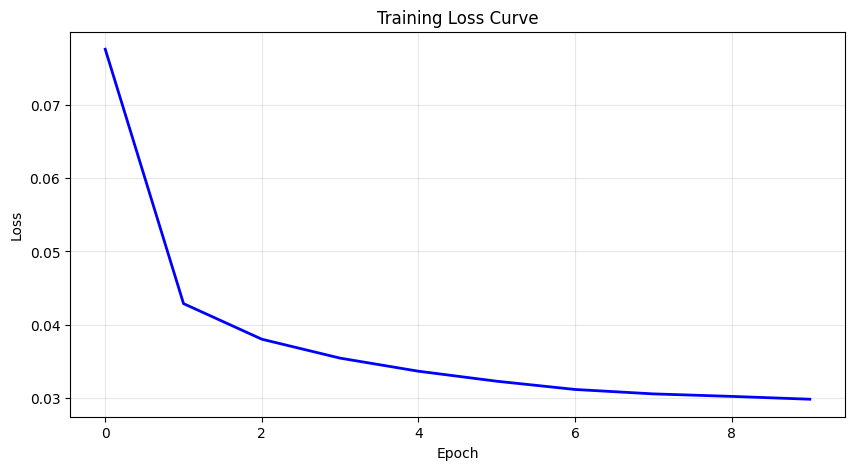


Generating final samples...


Sampling: 100%|██████████| 1000/1000 [00:40<00:00, 24.47it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14357626..1.148859].



Displaying final generated samples...


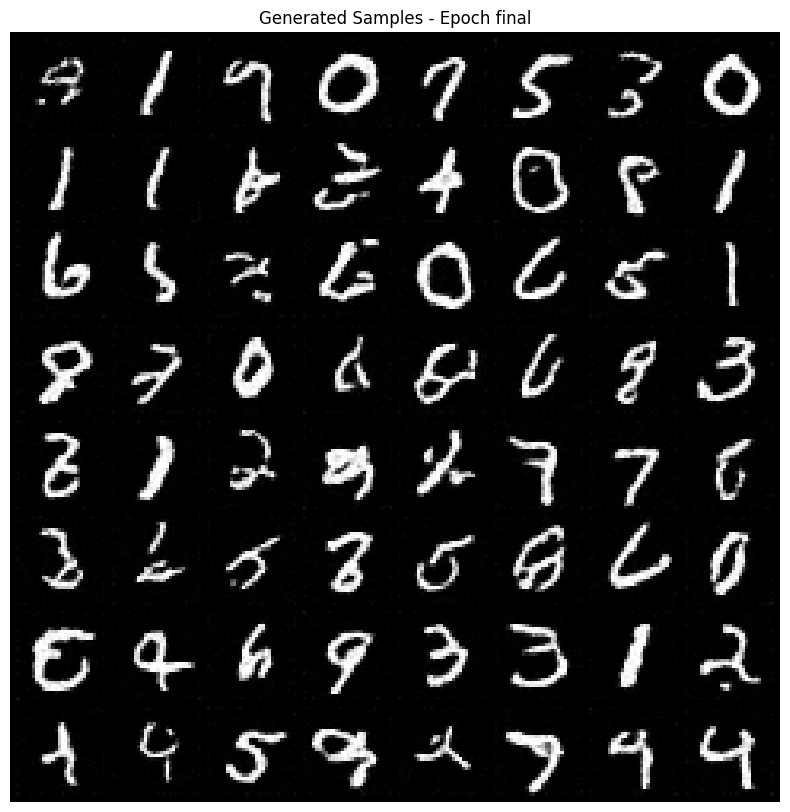

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3948517..2.3569174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4437025..2.858403].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3707496..2.4843507].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8038316..2.2580886].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5178115..2.5349603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4375503..2.2347426].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3441283


Displaying intermediate sampling steps...


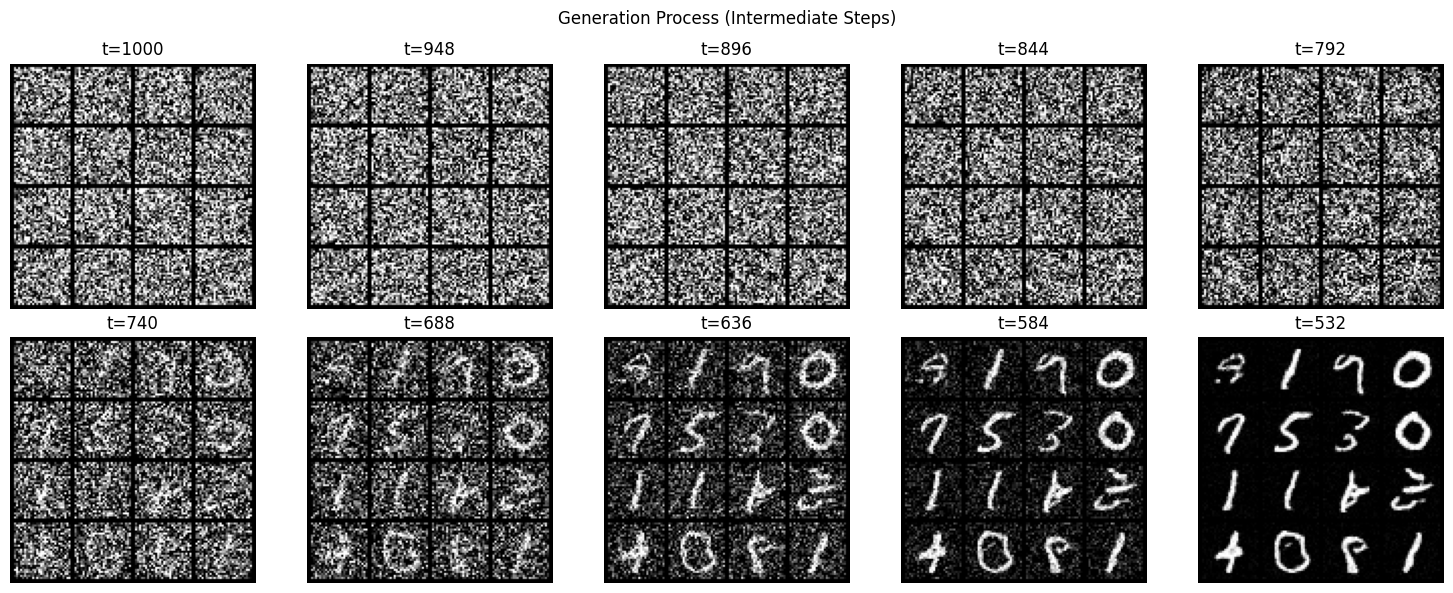


Generating test samples with fixed seeds...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.092623055..1.1240504].


Displaying samples with seed 42...


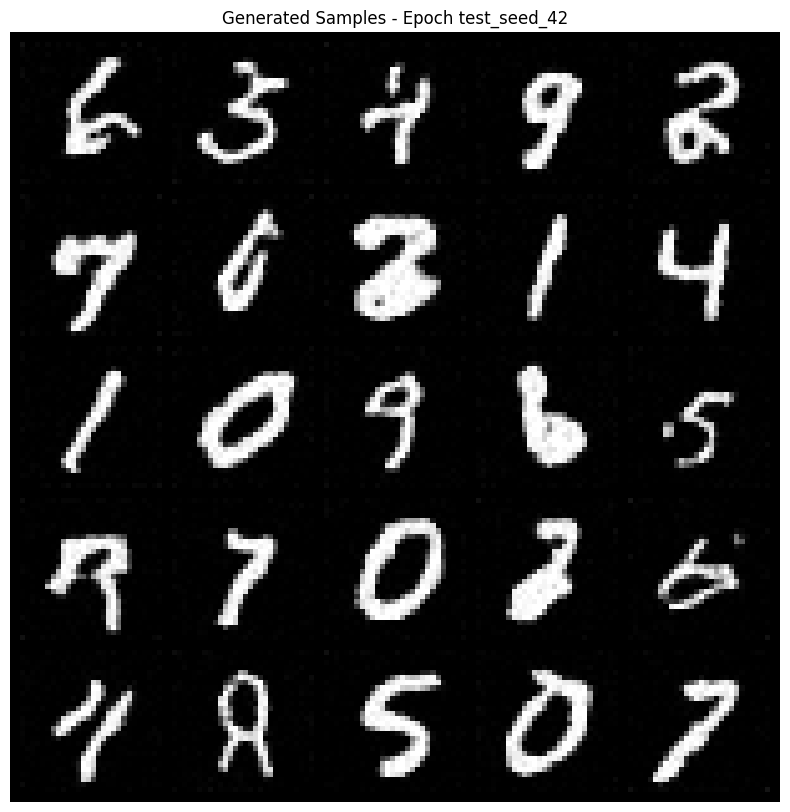


Generating additional samples for visualization...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16452539..1.1920862].


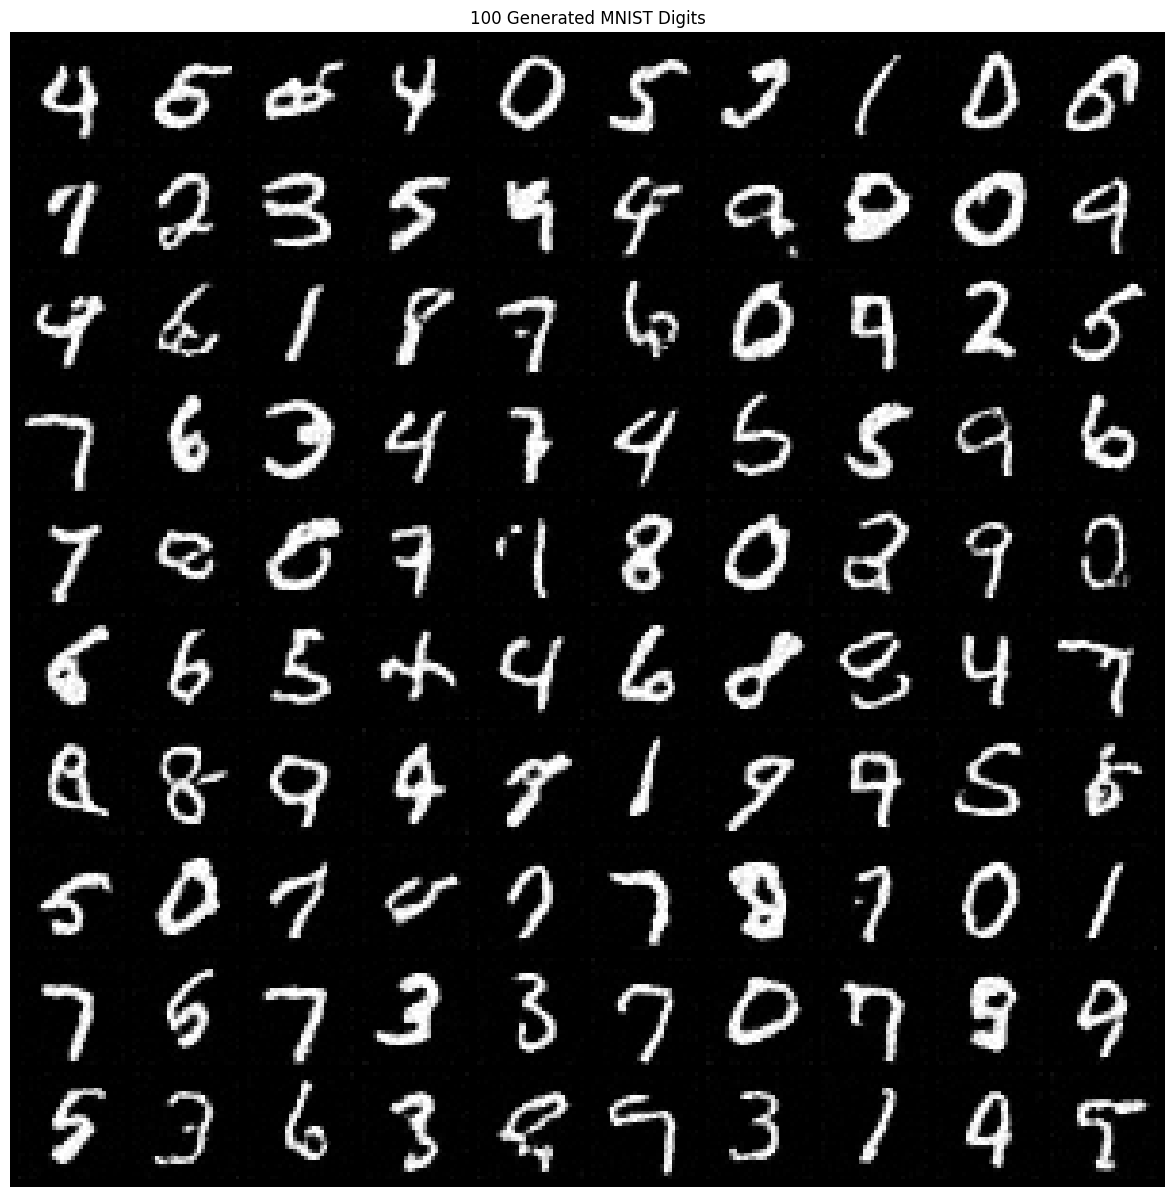


Training Summary:
- Final loss: 0.0299
- Model parameters: 8,165,697
- Total training steps: 4690
- Saved files:
  • samples_epoch_*.png - Generated samples during training
  • training_loss.png - Training loss curve
  • generation_process.png - Intermediate denoising steps
  • large_sample_grid.png - 100 generated digits
  • checkpoint_epoch_*.pth - Model checkpoints

Displaying real MNIST samples for comparison...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16452539..1.1920862].


In [ ]:
# Create directories
os.makedirs('samples', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

# Initialize model and diffusion
print("Initializing model...")
model = MNIST_UNet(in_channels=CHANNELS, out_channels=CHANNELS).to(device)
diffusion = DDPM(model, timesteps=TIMESTEPS, device=device)

# Print model summary
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

# Test a forward pass
print("Testing forward pass...")
test_input = torch.randn(2, 1, 28, 28).to(device)
test_t = torch.randint(0, TIMESTEPS, (2,)).to(device)
with torch.no_grad():
    output = model(test_input, test_t)
print(f"Input shape: {test_input.shape}, Output shape: {output.shape}")

# Get data loader
print("Loading data...")
train_loader = get_dataloaders()
print(f"Training batches: {len(train_loader)}")

# Train the model
print("Starting training...")
losses = train(model, diffusion, train_loader, epochs=EPOCHS)

# Display training curve
print("\nDisplaying training curve...")
display_training_curve(losses)

# Generate final samples
print("\nGenerating final samples...")
with torch.no_grad():
    # Generate 64 samples
    samples, intermediates = diffusion.sample(n_samples=64, verbose=True)
    
    # Save and display final samples
    print("\nDisplaying final generated samples...")
    save_samples(samples, "final", nrow=8, display=True)
    
    # Display intermediate steps
    print("\nDisplaying intermediate sampling steps...")
    display_intermediate_steps(intermediates)

# Test generation with specific seeds for reproducibility
print("\nGenerating test samples with fixed seeds...")
torch.manual_seed(42)
with torch.no_grad():
    test_samples, _ = diffusion.sample(n_samples=25, verbose=False)
    
    # Display seed-based samples
    print("Displaying samples with seed 42...")
    save_samples(test_samples, "test_seed_42", nrow=5, display=True)

# Generate more samples for better visualization
print("\nGenerating additional samples for visualization...")
torch.manual_seed(123)
with torch.no_grad():
    # Generate 100 samples for a better overview
    large_samples, _ = diffusion.sample(n_samples=100, verbose=False)
    
    # Display in a large grid
    plt.figure(figsize=(15, 15))
    grid = utils.make_grid((large_samples.cpu() + 1) / 2, nrow=10, padding=2, normalize=False)
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('100 Generated MNIST Digits')
    plt.savefig('large_sample_grid.png', bbox_inches='tight')
    plt.show()

print("\n" + "="*50)
print("Training Summary:")
print(f"- Final loss: {losses[-1]:.4f}")
print(f"- Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"- Total training steps: {len(train_loader) * EPOCHS}")
print(f"- Saved files:")
print(f"  • samples_epoch_*.png - Generated samples during training")
print(f"  • training_loss.png - Training loss curve")
print(f"  • generation_process.png - Intermediate denoising steps")
print(f"  • large_sample_grid.png - 100 generated digits")
print(f"  • checkpoint_epoch_*.pth - Model checkpoints")
print("="*50)

# Show some real MNIST samples for comparison
print("\nDisplaying real MNIST samples for comparison...")
real_samples = next(iter(train_loader))[0][:25]
real_grid = utils.make_grid((real_samples + 1) / 2, nrow=5, padding=2, normalize=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(real_grid.permute(1, 2, 0).squeeze(), cmap='gray')
ax1.set_title('Real MNIST Samples')
ax1.axis('off')

ax2.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
ax2.set_title('Generated Samples')
ax2.axis('off')

plt.tight_layout()
plt.savefig('comparison.png', bbox_inches='tight')
plt.show()

print("\nTraining completed! All visualizations have been displayed.") 